# Modeling and Simulation in Python
Christopher Pham: Modeling COVID-19 in Santa Clara County
Using the model from Chapter 11

Chapter 11
Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [19]:
!pip install pint
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


### SIR implementation

We'll use a `State` object to represent the number (or fraction) of people in each compartment.

In [20]:
init = State(S=1-200/60e6-20/60e6-1/60e6-2/60e6, I=200/60e6, D=20/60e6, A=1/60e6, R=2/60e6, T=0, H=0, E=0)

,values
S,9.999963e-01
I,3.333333e-06
D,3.333333e-07
A,1.666667e-08
R,3.333333e-08
T,0.000000e+00
H,0.000000e+00
E,0.000000e+00


To convert from number of people to fractions, we divide through by the total.

In [21]:
init /= sum(init)

,values
S,9.999963e-01
I,3.333333e-06
D,3.333333e-07
A,1.666667e-08
R,3.333333e-08
T,0.000000e+00
H,0.000000e+00
E,0.000000e+00


`make_system` creates a `System` object with the given parameters.

In [22]:
def make_system(alpha, beta, delta, gamma, epsilon, theta, zeta, eta, mu, nu, tau, lamda, rho, kappa, ksi, sigma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=1-200/60e6-20/60e6-1/60e6-2/60e6, I=200/60e6, D=20/60e6, A=1/60e6, R=2/60e6, T=0, H=0, E=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 28  # 28 more weeks

    return System(init=init, t0=t0, t_end=t_end,
                  alpha=alpha, beta=beta, delta=delta, gamma=gamma,
                  epsilon=epsilon, theta=theta, zeta=zeta, eta=eta,
                  mu=mu, nu=nu, tau=tau, lamda=lamda,
                  rho=rho, kappa=kappa, ksi=ksi, sigma=sigma)

Here's an example with hypothetical values for `beta` and `gamma`.

In [23]:
alpha = 0.57
beta = 0.011
delta = 0.011 
gamma = 0.456
epsilon = 0.171
theta = 0.371
zeta = 0.125
eta = 0.125
mu = 0.017
nu = 0.027
tau = 0.01
lamda = 0.034
rho = 0.034
kappa = 0.017
ksi = 0.017
sigma = 0.017 

system = make_system(alpha, beta, delta, gamma, epsilon, theta, zeta, eta, mu, nu, tau, lamda, rho, kappa, ksi, sigma)

,values
init,S 9.999963e-01 I 3.333333e-06 D 3.333...
t0,0
t_end,196
alpha,0.57
beta,0.011
delta,0.011
gamma,0.456
epsilon,0.171
theta,0.371
zeta,0.125


The update function takes the state during the current time step and returns the state during the next time step.

In [24]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, d, a, r, t, h, e = state

    infected1 = system.alpha * i * s
    infected2 = (system.epsilon + system.ksi + system.lamda) * i
    infected3 = system.epsilon * i
    infected4 = system.zeta * i
    infected5 = system.lamda * i
    
    diagnosed1 = system.beta * d * s
    diagnosed2 = (system.eta + system.rho) * d
    diagnosed3 = system.eta * d
    diagnosed4 = system.rho * d
    
    ailing1 = system.gamma * a * s
    ailing2 = (system.theta + system.mu + system.kappa) * a
    ailing3 = system.theta * a
    ailing4 = system.mu * a
    ailing5 = system.kappa * a
    
    recognized1 = system.delta * r * s
    recognized2 = (system.nu + system.ksi) * r
    recognized3 = system.nu * r
    recognized4 = system.ksi * r
    
    threatened = (system.nu + system.ksi) * t
    threatened1 = system.sigma * t
    
    extinct = system.tau * t
    
    s -= infected1 + diagnosed1 + ailing1 + recognized1
    i += (infected1 + diagnosed1 + ailing1 + recognized1) - infected2
    d += infected3 - diagnosed2
    a += infected4 - ailing2
    r += diagnosed3 + ailing3 - recognized2
    t += ailing4 + recognized3 - threatened
    h += infected5 + diagnosed4 + ailing5 + recognized4 + threatened1
    e += extinct
    
    return State(S=s, I=i, D=d, A=a, R=r, T=t, H=h, E=e)

To run a single time step, we call it like this:

In [25]:
state = update_func(init, 0, system)

,values
S,9.999944e-01
I,4.504960e-06
D,8.503333e-07
A,4.265833e-07
R,7.971667e-08
T,1.183333e-09
H,1.255167e-07
E,0.000000e+00


Now we can run a simulation by calling the update function for each time step.

In [26]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        
    return state

The result is the state of the system at `t_end`

In [27]:
run_simulation(system, update_func)

,values
S,2.399800e-02
I,2.213647e-06
D,3.277966e-06
A,7.654626e-07
R,1.347062e-03
T,5.452923e-03
H,1.021595e+00
E,1.564485e-01


**Exercise**  Suppose the County lifts the Shelter in Place order now.  After 28 weeks, how many students, total, have been infected?

Hint: what is the change in `S` between the beginning and the end of the simulation?

In [28]:
# Solution goes here

### Using TimeSeries objects

If we want to store the state of the system at each time step, we can use one `TimeSeries` object for each state variable.

In [29]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    D = TimeSeries()
    A = TimeSeries()
    R = TimeSeries()
    T = TimeSeries()
    H = TimeSeries()
    E = TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], D[t0], A[t0], R[t0], T[t0], H[t0], E[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        S[t+1], I[t+1], D[t+1], A[t+1], R[t+1], T[t+1], H[t+1], E[t+1] = state
    
    return S, I, D, A, R, T, H, E

Here's how we call it.

In [30]:
alpha = 0.57
beta = 0.011
delta = 0.011 
gamma = 0.456
epsilon = 0.171
theta = 0.371
zeta = 0.125
eta = 0.125
mu = 0.017
nu = 0.027
tau = 0.01
lamda = 0.034
rho = 0.034
kappa = 0.017
ksi = 0.017
sigma = 0.017 

system = make_system(alpha, beta, delta, gamma, epsilon, theta, zeta, eta, mu, nu, tau, lamda, rho, kappa, ksi, sigma)
S, I, D, A, R, T, H, E = run_simulation(system, update_func)

And then we can plot the results.

In [31]:
def plot_results(S, I, D, A, R, T, H, E):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(D, ':', label='Diagnosed')
    plot(A, '--', label='Ailing')
    plot(R, '-', label='Recognized')
    plot(T, ':', label='Threatened')
    plot(H, '--', label='Healed')
    plot(E, '-', label='Extinct')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's what they look like.

Saving figure to file D:/Spring 2022/SIR-Fig01.pdf


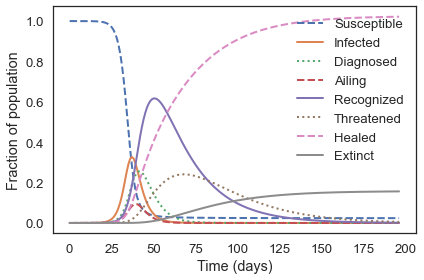

In [32]:
plot_results(S, I, D, A, R, T, H, E)
savefig('D:/Spring 2022/SIR-Fig01.pdf')

### Using a DataFrame

Instead of making three `TimeSeries` objects, we can use one `DataFrame`.

We have to use `row` to selects rows, rather than columns.  But then Pandas does the right thing, matching up the state variables with the columns of the `DataFrame`.

In [33]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

Here's how we run it, and what the result looks like.

In [34]:
alpha = 0.57
beta = 0.011
delta = 0.011 
gamma = 0.456
epsilon = 0.171
theta = 0.371
zeta = 0.125
eta = 0.125
mu = 0.017
nu = 0.027
tau = 0.01
lamda = 0.034
rho = 0.034
kappa = 0.017
ksi = 0.017
sigma = 0.017 

system = make_system(alpha, beta, delta, gamma, epsilon, theta, zeta, eta, mu, nu, tau, lamda, rho, kappa, ksi, sigma)
results = run_simulation(system, update_func)
results.head()

,S,I,D,A,R,T,H,E
0,0.999996,0.000003,3.333333e-07,1.666667e-08,3.333333e-08,0.000000e+00,0.000000e+00,0.000000e+00
1,0.999994,0.000005,8.503333e-07,4.265833e-07,7.971667e-08,1.183333e-09,1.255167e-07,0.000000e+00
2,0.999992,0.000006,1.485478e-06,8.169370e-07,3.407632e-07,1.053553e-08,3.162238e-07,1.183333e-11
3,0.999988,0.000009,2.322727e-06,1.270755e-06,8.145381e-07,3.316051e-08,6.000225e-07,1.171887e-10
4,0.999982,0.000013,3.467540e-06,1.862917e-06,1.540489e-06,7.529681e-08,1.016063e-06,4.487937e-10


We can extract the results and plot them.

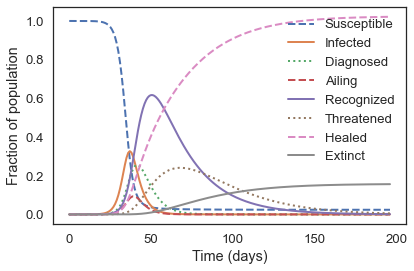

In [17]:
plot_results(results.S, results.I, results.D, results.A, results.R, results.T, results.H, results.E)